# Iris dataset classification with 2-layer neural network

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import load_iris
from sklearn.preprocessing import LabelBinarizer
import pyprind

import sys
sys.path.append('../')
from networks import *
from optimizers import *

In [5]:
iris = load_iris()
X = iris.data[:, :2]
y = iris.target
# standardize
mean = X.mean(axis=0)
std = X.std(axis=0)
X = (X - mean) / std
one_hot_y = np.array(LabelBinarizer().fit_transform(y).T)

clf = NeuralNetwork(X.shape[1], 50, 3)

In [11]:
epochs = 10000
bar = pyprind.ProgBar(epochs, bar_char='█', width=60, track_time=True, stream=1)
for epoch in range(0, epochs):
    sgd(clf, X, one_hot_y, learning_rate=0.0001)
    bar.update(item_id = "loss = {0:.2f}".format(clf.loss.value))

clf.forward_backward({ clf.x_in: X.T, clf.one_hot_y_in: one_hot_y})
y_pred = np.argmax(clf.output.value, axis=0)

accuracy = np.sum(y_pred == y) / len(y)
accuracy

0%                                                        100%
[████████████████████████████████████████████████████████████] | ETA: 00:00:00 | Item ID: loss = 21.33
Total time elapsed: 00:00:06


0.8666666666666667

/Users/kirill/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


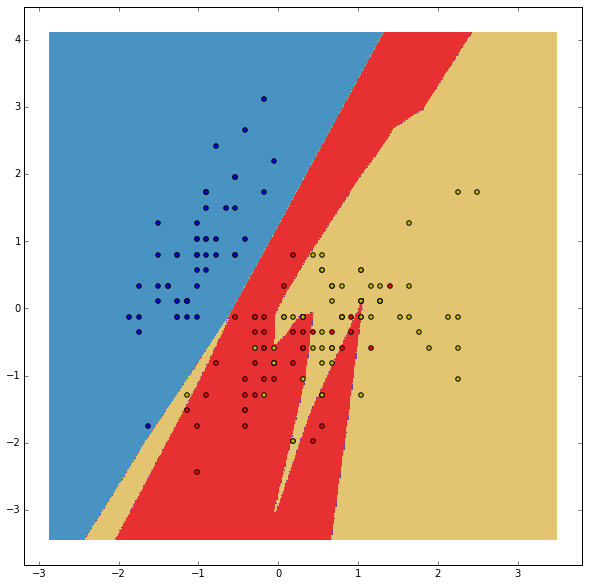

In [12]:
colors = "bry"
fig = plt.figure()
   
h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

mps = np.c_[xx.ravel(), yy.ravel()]
clf.one_hot_y_in.value = np.ones(shape=(3, len(mps)))
Z = np.argmax(clf.predict(mps), axis=0)
# Put the result into a color plot
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

for i, color in zip(np.unique(iris.target), colors):
    idx = np.where(y == i)
    plt.scatter(X[y == i, 0], X[y == i, 1], c=color, label=iris.target_names[i], cmap=plt.cm.Paired)

plt.axis('tight')
fig.set_size_inches(10, 10)